**Test2Achieve - Roberta.ipynb**

**Team: * Bharat Sharma * Adithya Vinod * Shanmukha Sai Penumatsa**

**Course: DAAN 570 Deep Learning (Spring I, 2023)**

**Problem Statement:**

We have tried to solve this problem by breaking it down into two independent problem statements, namely: 

Automated Answer Generation: 
We will be using pretrained models like Bert, Roberta, Albert and Electra for answer generation tasks, where given a question or prompt, the model generates an answer. These models are trained on large amounts of text data and can learn to generate coherent and accurate responses. 

Automated Grading: 
The answer and scores are first passed through the LSTM which are then passed through the multiple neural layers to train the model. The trained model will return a score for each answer based on historic grading.

In this python notebook we will be using ROBERTA - a pretrained language model to solve the answer generation problem statement.


In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Data Collection:**

We have used SQUAD 2.0 dataset for building the neural network for answer generation. It consists of a context along with a set of questions and their respective answers.

We have used python function !wget to save the JSON data from the link https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

In [ ]:
 %%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

**Required Package:** 

Transformers are not an inbuild packages in Colab and it needs to be installed seperately using pip install.

In [ ]:
%%capture
!pip install transformers

In [ ]:
import os

os.getcwd() # prints current working directory

'/content'

In [ ]:
os.listdir() # prints the contents of the current working directory

['.config', 'drive', 'squad', 'sample_data']

## Retrieve and Store the data

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists. Below is a screenshot of how the JSON format looks for each title and paragraphs

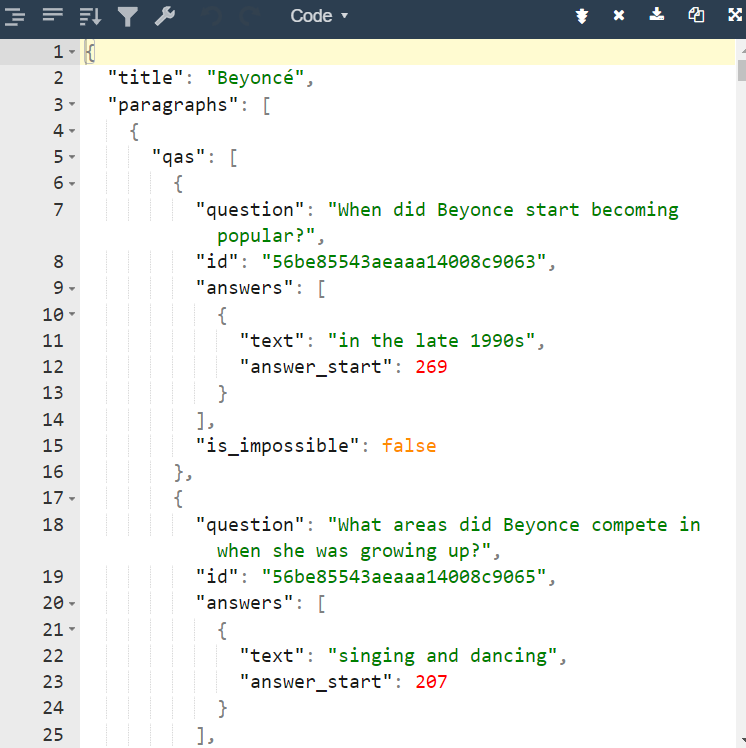

In [ ]:
# Give the path for train data
path = Path('squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
# Printing the sample of 10 cases of information stored in above strings
train_texts_print = train_texts[:10]
print("############# Train texts ####################")
print(train_texts_print)
train_queries_print = train_queries[:10]
print("############# train_queries ####################")
print(train_queries_print)
train_answers_print = train_answers[:10]
print("############# train_answers ####################")
train_answers_print

############# Train texts ####################
['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child

[{'text': 'in the late 1990s', 'answer_start': 269},
 {'text': 'singing and dancing', 'answer_start': 207},
 {'text': '2003', 'answer_start': 526},
 {'text': 'Houston, Texas', 'answer_start': 166},
 {'text': 'late 1990s', 'answer_start': 276},
 {'text': "Destiny's Child", 'answer_start': 320},
 {'text': 'Dangerously in Love', 'answer_start': 505},
 {'text': 'Mathew Knowles', 'answer_start': 360},
 {'text': 'late 1990s', 'answer_start': 276},
 {'text': 'lead singer', 'answer_start': 290}]

In [ ]:
# Give the path for validation data
path = Path('squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

In [ ]:
# Printing the sample of 10 cases of information stored in above strings
val_texts_print = val_texts[:10]
print("############# Train texts ####################")
print(val_texts_print)
val_queries_print = val_queries[:10]
print("############# train_queries ####################")
print(val_queries_print)
val_answers_print = val_answers[:10]
print("############# train_answers ####################")
val_answers_print

############# Train texts ####################
['The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norma

[{'text': 'France', 'answer_start': 159},
 {'text': 'France', 'answer_start': 159},
 {'text': 'France', 'answer_start': 159},
 {'text': 'France', 'answer_start': 159},
 {'text': '10th and 11th centuries', 'answer_start': 94},
 {'text': 'in the 10th and 11th centuries', 'answer_start': 87},
 {'text': '10th and 11th centuries', 'answer_start': 94},
 {'text': '10th and 11th centuries', 'answer_start': 94},
 {'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
 {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]

In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers)) 

86821
86821
86821


In [ ]:
print("Passage: ",train_texts[0])  
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
# Initial model - 1
#train_texts = train_texts[:20000]
#train_queries = train_queries[:20000]
#train_answers = train_answers[:20000]

#val_texts = val_texts[:20000]
#val_queries = val_queries[:20000]
#val_answers = val_answers[:20000]


# Initial model - 2
train_texts = train_texts[:40000]
train_queries = train_queries[:40000]
train_answers = train_answers[:40000]

val_texts = val_texts[:40000]
val_queries = val_queries[:40000]
val_answers = val_answers[:40000]

# print(len(train_texts))
# print(len(train_queries))
# print(len(train_answers))


# print(len(val_texts))
# print(len(val_queries))
# print(len(val_answers))

**Data Preprocessing:**

Finding the end position character is a very important input for all the answer generation models as it needs both start and end position characters of the answer. This needs to be found and stored.


In [ ]:
# Preprocessing on train set
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2    

In [ ]:
# Preprocessing on test set
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2   

**Methodology:**

1. Tokenize the text.
2. Identifying the start and end position of each answer.
3. Using pre-trained models to train the model.
4. Evaluating the performance using F1 score and loss values.
5. Model weights are saved.

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

In [ ]:
# Checking the elements of the output of tokeniser
# Iterate through the encoded sequences and attention masks
for i in range(2):
    print(f"Text input: {train_texts[i]}")
    print(f"Query input: {train_queries[i]}")
    print(f"Encoded sequence: {train_encodings['input_ids'][i]}")
    print(f"Attention mask: {train_encodings['attention_mask'][i]}")
    print()

Text input: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query input: When did Beyonce start becoming popular?
Encoded sequence: [101, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220,

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

2
16


Create a Dataset class 

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

Use of DataLoader to split the data into batches


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Checking if GPU is working

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## Building the Bert model

**Model Fitting and Validation:**

1. Bert model is used to fit the model with Bert-base-uncased tokenisation.
2. Adam optimiser is used.
3. Learning rate is 5e-5.
4. Number of epochs is 3. 


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForQuestionAnswering, GPT2Tokenizer, GPT2LMHeadModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from transformers.data.processors.squad import SquadV1Processor, SquadV2Processor
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)


# Set up variables for training
epochs = 3

# Set up tokenizer for BERT and ChatGPT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set up BERT model
bert_model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

# Set up ChatGPT model
#gpt_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

# Set up optimizer for both models
optimizer = AdamW(bert_model.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)


# Set up loss function for both models
loss_fn = nn.CrossEntropyLoss().to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## ***Step 11:*** Train and Evaluate Model

In [ ]:
# Set up variables for training
# epochs = 2

whole_train_eval_time = time.time()
train_losses = []
val_losses = []

agg_train_losses = []
agg_val_losses = []

# Train the models
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))

    loss_of_epoch = 0

    # Train the BERT model
    bert_model.train()
    for batch in train_data_loader:
        #input_ids = batch['input_ids'].to(device)
        #attention_mask = torch.tensor([bert_tokenizer.encode(text, add_special_tokens=True, padding='max_length', truncation='longest_first')[1:] for text in batch.text]).to(device)
        #start_positions = torch.tensor(batch.start_positions).to(device)
        #end_positions = torch.tensor(batch.end_positions).to(device)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
    

    


        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        
        train_losses.append(loss.item())


        loss_of_epoch += loss.item()
        loss_of_epoch /= len(train_data_loader)
        agg_train_losses.append(loss_of_epoch)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluate the BERT model
    bert_model.eval()
    for batch in val_data_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = bert_model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            val_losses.append(loss.item())

            loss_of_epoch += loss.item()
            loss_of_epoch /= len(val_data_loader)
            agg_val_losses.append(loss_of_epoch)


print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

Epoch 1/3
Epoch 2/3
Epoch 3/3
Total training and evaluation time:  13087.135095119476


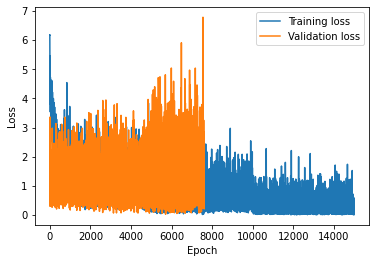

In [ ]:
import matplotlib.pyplot as plt

# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# Save model
#torch.save(model,"/content/drive/MyDrive/Deep learning/Project/model1")
from google.colab import drive
drive.mount('/content/drive')

#!mkdir "/content/drive/My Drive/my_model_directory"

#torch.save(model.state_dict(), "/content/drive/My Drive/my_model_directory/my_model_4.pt")

torch.save(bert_model.state_dict(), "/content/drive/My Drive/my_model_directory/my_model_bert_gpt.pt")

#torch.save(model,"/content/drive/My Drive/Deep learning/Project/model1")
#torch.save(model,"/content/drive/MyDrive/Deep learning")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ***Step 12:*** Plot train and validation losses

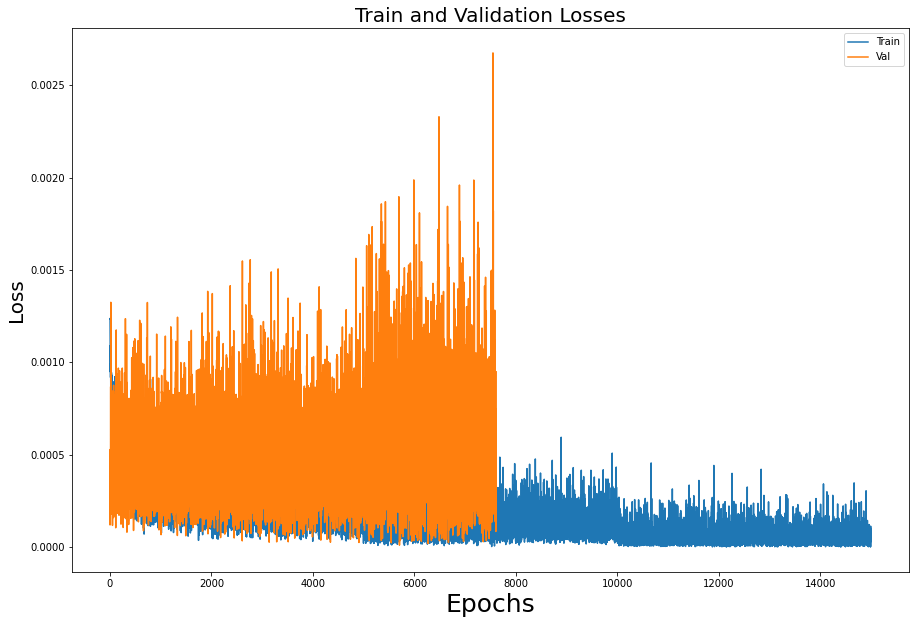

In [ ]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(agg_train_losses)
_=ax.plot(agg_val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

Note: The above graph shows epochs ranging 12,000 because the dataloader splits into multiple batches and each model run is being considered as epoch. This is a small error during the final run of the code before submission, this could be corrected by using code - 
  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch). 

Apologies for no corrections in last run

**Model Evaluation:**

1. Loss graph is plotted to see the performance on the train and validation dataset. From graph, we can say that train loss is decreasing and validation loss almost remains the same

2. In further next steps, the model is put against the test dataset to calculate the F1 score and exact match score.

### Saving the model and Loading the fine tuned model back

In [ ]:
# Define the bert tokenizer
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

from google.colab import drive
drive.mount('/content/drive')
# Load the fine-tuned modeol
#model = torch.load("/content/drive/My Drive/my_model_directory/my_model.pt",map_location=torch.device('cpu'))
#model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the model
from transformers import BertForQuestionAnswering

#model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
# Load the saved state dictionary from the file
#loaded_dict = torch.load("/content/drive/My Drive/my_model_directory/my_model.pt")

loaded_dict = torch.load("/content/drive/My Drive/my_model_directory/my_model_bert_gpt.pt", map_location=torch.device('cpu'))


# Create a new instance of the model
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Load the state dictionary into the model
model.load_state_dict(loaded_dict)

# Set the model to evaluation mode
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

### Making the prediction and evaluate it

In [ ]:
model = bert_model

def predict(context,query):

  #inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
  inputs = tokenizer.encode_plus(query, context, return_tensors='pt').to('cuda:0')

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

## Testing my model
Here I give some examples to my model to see how well I trained it. I started with more easier examples and then I gave it more complex ones.

For extractive textual QA tasks, we usually adopt two evaluation metrics, which measure exact match and partially overlapped scores respectively.

Exact Match: measures whether the predicted answer exactly matches the ground-truth answers. If the exact matching occurs, then assigns 1.0, otherwise assigns 0.0.
F1 Score: computes the average word overlap between predicted and ground-truth answers, which can ensure both of precision and recall rate are optimized at the same time.
As you can see my model predicted all the answers correct in a very small an easy example.

In [ ]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           ""
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: 
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0


Question: What is caused by COVID-19?
Prediction: severe acute respiratory syndrome coronavirus 2 ( sars - cov - 2 ). it was first identified in december 2019 in wuhan, china. the world health organization declared the outbreak a public health emergency of international concern in january 2020 and a pandemic in march 2020. as of 6 february 2021, more than 105 million cases have been confirmed, with more than 2. 3 million deaths attributed to covid - 19. symptoms of covid - 19 are highly variable, ranging from none to severe illness. the virus spreads mainly through the air when people are near each other. [ b ] it leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes.
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0.10434782608695652


Question: How many cases have b

In [ ]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near 
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between 
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi) 
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak, 
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). It is one of the 
              highest peaks in Europe in terms of topographic prominence. """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction: 52 peaks and deep gorges. the highest peak, mytikas, meaning " nose ", rises to 2917
True Answer: 2917
EM: 0
F1: 0.14285714285714288


Question: Where Olympus is near?
Prediction: the gulf of thermai of the aegean sea,
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 0
F1: 0.6666666666666666


Question: How far away is Olympus from Thessaloniki?
Prediction: 80 km ( 50 mi ) southwest from thessaloniki. mount olympus has 52 peaks and deep gorges. the highest peak, mytikas,
True Answer: 80 km (50 mi)
EM: 0
F1: 0.3636363636363636




In [ ]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: j. k. rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: hermione granger and ron weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: lord voldemort,
True Answer: Lord Voldemort
EM: 1
F1: 1.0


Question: What are Muggles?
Prediction: non - magical people )
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: hermione granger and ron weasley,
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0.20000000000000004


Question: When did the first novel release?
Prediction: 26 june 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction: hermione granger and ron weasley,
True Answer: a wide adult audience as well as younger readers
EM: 0
F1: 0


Question: How many languages Harry

**Improvements:**
1. Model could be trained on more epochs given more computational power.
2. Improved quality and quantity of the dataset could improve the performance of the model as well.

**References:**
1. https://www.kaggle.com/competitions/asap-sas/data
2. https://towardsdatascience.com/question-answering-with-pretrained-transformers-using-pytorch-c3e7a44b4012

**Credits:**
1. https://huggingface.co/docs/transformers/tasks/question_answering
2. https://github.com/alexaapo/BERT-based-pretrained-model-using-SQuAD-2.0-dataset